In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os
from accelerate import Accelerator

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/division_non/non.infringement.json'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/division_non/non.non_infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_f1 = -float('inf')  # Initialize the best F1-score to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # Calculate F1-score
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Check if the current model is the best based on F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with F1-score {best_f1:.4f} and accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


accelerator = Accelerator()
model, non_infringement_outputs, infringement_outputs = accelerator.prepare(model, non_infringement_outputs, infringement_outputs)

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 17/17 [00:03<00:00,  4.48it/s]


[[-0.97691166 -2.6787107   2.709472   ...  0.4441366  -1.8452275
  -0.01699742]
 [-1.213785   -3.39166     3.283101   ...  0.72158587 -0.9341987
  -1.8595335 ]
 [-0.7662403  -3.0785556   3.2414572  ...  0.86271614 -1.2234137
  -0.7212765 ]
 ...
 [-1.3260019  -2.252502    2.0059788  ...  2.3639536  -1.1374267
  -0.8060565 ]
 [-1.5414072  -2.489604    1.6685303  ... -0.16673551 -0.67592657
   0.9024208 ]
 [-2.229042   -2.7402632   4.3669233  ...  0.92628914 -0.86009157
  -0.5396229 ]]
Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 17/17 [00:03<00:00,  4.41it/s]


: 

In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")


Data successfully split into training and test sets.


Training Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

Training Epochs:   1%|          | 18/2000 [00:00<00:47, 41.86it/s]

Epoch 10/2000, Loss: 5.2299
Test Accuracy at Epoch 10: 53.57%
Test F1-score at Epoch 10: 0.6829
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       1.00      0.07      0.13        14
non_infringement       0.52      1.00      0.68        14

        accuracy                           0.54        28
       macro avg       0.76      0.54      0.41        28
    weighted avg       0.76      0.54      0.41        28

New best model saved with F1-score 0.6829 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       1.00      0.07      0.13        14
non_infringement       0.52      1.00      0.68        14

        accuracy                           0.54        28
       macro avg       0.76      0.54      0.41        28
    weighted avg       0.76      0.54      0.41        28



Training Epochs:   1%|▏         | 29/2000 [00:00<00:33, 58.95it/s]

Epoch 20/2000, Loss: 0.3813
Test Accuracy at Epoch 20: 57.14%
Test F1-score at Epoch 20: 0.6667
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.67      0.29      0.40        14
non_infringement       0.55      0.86      0.67        14

        accuracy                           0.57        28
       macro avg       0.61      0.57      0.53        28
    weighted avg       0.61      0.57      0.53        28

Epoch 30/2000, Loss: 0.3306
Test Accuracy at Epoch 30: 60.71%
Test F1-score at Epoch 30: 0.6857
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.71      0.36      0.48        14
non_infringement       0.57      0.86      0.69        14

        accuracy                           0.61        28
       macro avg       0.64      0.61      0.58        28
    weighted avg       0.64      0.61      0.58        28

New best model saved with F1-score 0

Training Epochs:   2%|▏         | 49/2000 [00:00<00:25, 77.15it/s]

Epoch 40/2000, Loss: 0.1714
Test Accuracy at Epoch 40: 78.57%
Test F1-score at Epoch 40: 0.7857
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.79      0.79      0.79        14
non_infringement       0.79      0.79      0.79        14

        accuracy                           0.79        28
       macro avg       0.79      0.79      0.79        28
    weighted avg       0.79      0.79      0.79        28

New best model saved with F1-score 0.7857 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.79      0.79      0.79        14
non_infringement       0.79      0.79      0.79        14

        accuracy                           0.79        28
       macro avg       0.79      0.79      0.79        28
    weighted avg       0.79      0.79      0.79        28

Epoch 50/2000, Loss: 0.0543
Test Accuracy at Epoch 50: 71.43%
Test F1-sco

Training Epochs:   4%|▍         | 85/2000 [00:01<00:18, 100.93it/s]

Epoch 70/2000, Loss: 0.0037
Test Accuracy at Epoch 70: 71.43%
Test F1-score at Epoch 70: 0.7500
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 80/2000, Loss: 0.0020
Test Accuracy at Epoch 80: 71.43%
Test F1-score at Epoch 80: 0.7500
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 90/2000, Loss: 0.0013
Test Acc

Training Epochs:   6%|▌         | 124/2000 [00:01<00:15, 117.51it/s]

Epoch 100/2000, Loss: 0.0010
Test Accuracy at Epoch 100: 71.43%
Test F1-score at Epoch 100: 0.7500
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 110/2000, Loss: 0.0009
Test Accuracy at Epoch 110: 71.43%
Test F1-score at Epoch 110: 0.7500
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 120/2000, Loss: 0.0008

Training Epochs:   8%|▊         | 150/2000 [00:01<00:15, 117.66it/s]

Epoch 130/2000, Loss: 0.0007
Test Accuracy at Epoch 130: 71.43%
Test F1-score at Epoch 130: 0.7500
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 140/2000, Loss: 0.0006
Test Accuracy at Epoch 140: 71.43%
Test F1-score at Epoch 140: 0.7500
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 150/2000, Loss: 0.0005

Training Epochs:   9%|▊         | 174/2000 [00:01<00:15, 114.90it/s]

Epoch 160/2000, Loss: 0.0005
Test Accuracy at Epoch 160: 71.43%
Test F1-score at Epoch 160: 0.7500
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 170/2000, Loss: 0.0004
Test Accuracy at Epoch 170: 71.43%
Test F1-score at Epoch 170: 0.7500
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 180/2000, Loss: 0.0004

Training Epochs:  10%|█         | 210/2000 [00:02<00:15, 113.73it/s]

Epoch 190/2000, Loss: 0.0004
Test Accuracy at Epoch 190: 71.43%
Test F1-score at Epoch 190: 0.7500
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 200/2000, Loss: 0.0003
Test Accuracy at Epoch 200: 71.43%
Test F1-score at Epoch 200: 0.7500
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 210/2000, Loss: 0.0003

Training Epochs:  12%|█▏        | 235/2000 [00:02<00:15, 117.27it/s]

Epoch 220/2000, Loss: 0.0003
Test Accuracy at Epoch 220: 71.43%
Test F1-score at Epoch 220: 0.7500
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 230/2000, Loss: 0.0003
Test Accuracy at Epoch 230: 71.43%
Test F1-score at Epoch 230: 0.7500
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 240/2000, Loss: 0.0003

Training Epochs:  13%|█▎        | 260/2000 [00:02<00:14, 117.39it/s]

Epoch 250/2000, Loss: 0.0002
Test Accuracy at Epoch 250: 71.43%
Test F1-score at Epoch 250: 0.7500
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 260/2000, Loss: 0.0002
Test Accuracy at Epoch 260: 71.43%
Test F1-score at Epoch 260: 0.7500
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 270/2000, Loss: 0.0002

Training Epochs:  14%|█▍        | 283/2000 [00:02<00:16, 101.31it/s]

Test Accuracy at Epoch 270: 71.43%
Test F1-score at Epoch 270: 0.7500
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 280/2000, Loss: 0.0002
Test Accuracy at Epoch 280: 71.43%
Test F1-score at Epoch 280: 0.7500
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs:  16%|█▌        | 310/2000 [00:03<00:15, 110.23it/s]

Epoch 290/2000, Loss: 0.0002
Test Accuracy at Epoch 290: 71.43%
Test F1-score at Epoch 290: 0.7500
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 300/2000, Loss: 0.0002
Test Accuracy at Epoch 300: 71.43%
Test F1-score at Epoch 300: 0.7500
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 310/2000, Loss: 0.0002

Training Epochs:  17%|█▋        | 334/2000 [00:03<00:14, 111.80it/s]

Epoch 320/2000, Loss: 0.0002
Test Accuracy at Epoch 320: 71.43%
Test F1-score at Epoch 320: 0.7500
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 330/2000, Loss: 0.0002
Test Accuracy at Epoch 330: 71.43%
Test F1-score at Epoch 330: 0.7500
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 340/2000, Loss: 0.0001

Training Epochs:  19%|█▉        | 375/2000 [00:03<00:12, 125.16it/s]

Epoch 350/2000, Loss: 0.0001
Test Accuracy at Epoch 350: 71.43%
Test F1-score at Epoch 350: 0.7500
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 360/2000, Loss: 0.0001
Test Accuracy at Epoch 360: 71.43%
Test F1-score at Epoch 360: 0.7500
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 370/2000, Loss: 0.0001

Training Epochs:  19%|█▉        | 389/2000 [00:03<00:12, 128.20it/s]

Epoch 380/2000, Loss: 0.0001
Test Accuracy at Epoch 380: 71.43%
Test F1-score at Epoch 380: 0.7500
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 390/2000, Loss: 0.0001
Test Accuracy at Epoch 390: 71.43%
Test F1-score at Epoch 390: 0.7500
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 400/2000, Loss: 0.0001

Training Epochs:  21%|██        | 415/2000 [00:04<00:13, 119.30it/s]

Epoch 410/2000, Loss: 0.0001
Test Accuracy at Epoch 410: 71.43%
Test F1-score at Epoch 410: 0.7500
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 420/2000, Loss: 0.0001
Test Accuracy at Epoch 420: 71.43%
Test F1-score at Epoch 420: 0.7500
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs:  22%|██▏       | 440/2000 [00:04<00:14, 104.10it/s]

Epoch 430/2000, Loss: 0.0001
Test Accuracy at Epoch 430: 71.43%
Test F1-score at Epoch 430: 0.7500
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 440/2000, Loss: 0.0001
Test Accuracy at Epoch 440: 71.43%
Test F1-score at Epoch 440: 0.7500
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 450/2000, Loss: 0.0001

Training Epochs:  23%|██▎       | 462/2000 [00:04<00:15, 97.87it/s] 

Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 460/2000, Loss: 0.0001
Test Accuracy at Epoch 460: 71.43%
Test F1-score at Epoch 460: 0.7500
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs:  24%|██▍       | 484/2000 [00:04<00:15, 99.45it/s]

Epoch 470/2000, Loss: 0.0001
Test Accuracy at Epoch 470: 71.43%
Test F1-score at Epoch 470: 0.7500
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 480/2000, Loss: 0.0001
Test Accuracy at Epoch 480: 71.43%
Test F1-score at Epoch 480: 0.7500
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 490/2000, Loss: 0.0001

Training Epochs:  25%|██▌       | 507/2000 [00:04<00:14, 105.35it/s]

Epoch 500/2000, Loss: 0.0001
Test Accuracy at Epoch 500: 71.43%
Test F1-score at Epoch 500: 0.7500
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 510/2000, Loss: 0.0001
Test Accuracy at Epoch 510: 71.43%
Test F1-score at Epoch 510: 0.7500
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs:  26%|██▋       | 528/2000 [00:05<00:15, 96.34it/s] 

Epoch 520/2000, Loss: 0.0001
Test Accuracy at Epoch 520: 71.43%
Test F1-score at Epoch 520: 0.7500
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 530/2000, Loss: 0.0001
Test Accuracy at Epoch 530: 71.43%
Test F1-score at Epoch 530: 0.7500
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 540/2000, Loss: 0.0001

Training Epochs:  28%|██▊       | 551/2000 [00:05<00:15, 91.05it/s] 

Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 550/2000, Loss: 0.0001
Test Accuracy at Epoch 550: 71.43%
Test F1-score at Epoch 550: 0.7500
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs:  29%|██▉       | 576/2000 [00:05<00:13, 104.71it/s]

Epoch 560/2000, Loss: 0.0001
Test Accuracy at Epoch 560: 71.43%
Test F1-score at Epoch 560: 0.7500
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 570/2000, Loss: 0.0001
Test Accuracy at Epoch 570: 71.43%
Test F1-score at Epoch 570: 0.7500
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 580/2000, Loss: 0.0001

Training Epochs:  30%|███       | 600/2000 [00:05<00:13, 107.26it/s]

Epoch 590/2000, Loss: 0.0001
Test Accuracy at Epoch 590: 71.43%
Test F1-score at Epoch 590: 0.7500
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 600/2000, Loss: 0.0001
Test Accuracy at Epoch 600: 71.43%
Test F1-score at Epoch 600: 0.7500
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs:  31%|███       | 624/2000 [00:06<00:13, 105.58it/s]

Epoch 610/2000, Loss: 0.0001
Test Accuracy at Epoch 610: 71.43%
Test F1-score at Epoch 610: 0.7500
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 620/2000, Loss: 0.0001
Test Accuracy at Epoch 620: 71.43%
Test F1-score at Epoch 620: 0.7500
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 630/2000, Loss: 0.0000

Training Epochs:  32%|███▎      | 650/2000 [00:06<00:11, 115.45it/s]

Epoch 640/2000, Loss: 0.0000
Test Accuracy at Epoch 640: 71.43%
Test F1-score at Epoch 640: 0.7500
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 650/2000, Loss: 0.0000
Test Accuracy at Epoch 650: 71.43%
Test F1-score at Epoch 650: 0.7500
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs:  34%|███▎      | 671/2000 [00:06<00:23, 56.14it/s] 

Epoch 660/2000, Loss: 0.0000
Test Accuracy at Epoch 660: 71.43%
Test F1-score at Epoch 660: 0.7500
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 670/2000, Loss: 0.0000
Test Accuracy at Epoch 670: 71.43%
Test F1-score at Epoch 670: 0.7500
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs:  35%|███▌      | 706/2000 [00:07<00:14, 86.33it/s]

Epoch 680/2000, Loss: 0.0000
Test Accuracy at Epoch 680: 71.43%
Test F1-score at Epoch 680: 0.7500
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 690/2000, Loss: 0.0000
Test Accuracy at Epoch 690: 71.43%
Test F1-score at Epoch 690: 0.7500
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 700/2000, Loss: 0.0000

Training Epochs:  37%|███▋      | 732/2000 [00:07<00:12, 101.93it/s]

Epoch 710/2000, Loss: 0.0000
Test Accuracy at Epoch 710: 71.43%
Test F1-score at Epoch 710: 0.7500
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 720/2000, Loss: 0.0000
Test Accuracy at Epoch 720: 71.43%
Test F1-score at Epoch 720: 0.7500
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 730/2000, Loss: 0.0000

Training Epochs:  38%|███▊      | 758/2000 [00:07<00:11, 107.95it/s]

Epoch 740/2000, Loss: 0.0000
Test Accuracy at Epoch 740: 71.43%
Test F1-score at Epoch 740: 0.7500
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 750/2000, Loss: 0.0000
Test Accuracy at Epoch 750: 71.43%
Test F1-score at Epoch 750: 0.7500
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 760/2000, Loss: 0.0000

Training Epochs:  39%|███▉      | 782/2000 [00:08<00:12, 98.64it/s] 

Epoch 770/2000, Loss: 0.0000
Test Accuracy at Epoch 770: 71.43%
Test F1-score at Epoch 770: 0.7500
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 780/2000, Loss: 0.0000
Test Accuracy at Epoch 780: 71.43%
Test F1-score at Epoch 780: 0.7500
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 790/2000, Loss: 0.0000

Training Epochs:  40%|████      | 804/2000 [00:08<00:14, 80.21it/s]

Epoch 800/2000, Loss: 0.0000
Test Accuracy at Epoch 800: 71.43%
Test F1-score at Epoch 800: 0.7500
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs:  41%|████▏     | 827/2000 [00:08<00:12, 93.69it/s]

Epoch 810/2000, Loss: 0.0000
Test Accuracy at Epoch 810: 71.43%
Test F1-score at Epoch 810: 0.7500
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 820/2000, Loss: 0.0000
Test Accuracy at Epoch 820: 71.43%
Test F1-score at Epoch 820: 0.7500
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 830/2000, Loss: 0.0000

Training Epochs:  43%|████▎     | 863/2000 [00:08<00:10, 107.29it/s]

Epoch 840/2000, Loss: 0.0000
Test Accuracy at Epoch 840: 71.43%
Test F1-score at Epoch 840: 0.7500
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 850/2000, Loss: 0.0000
Test Accuracy at Epoch 850: 71.43%
Test F1-score at Epoch 850: 0.7500
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 860/2000, Loss: 0.0000

Training Epochs:  45%|████▍     | 891/2000 [00:09<00:09, 117.48it/s]

Epoch 870/2000, Loss: 0.0000
Test Accuracy at Epoch 870: 71.43%
Test F1-score at Epoch 870: 0.7500
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 880/2000, Loss: 0.0000
Test Accuracy at Epoch 880: 71.43%
Test F1-score at Epoch 880: 0.7500
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 890/2000, Loss: 0.0000

Training Epochs:  46%|████▌     | 916/2000 [00:09<00:09, 118.57it/s]

Epoch 900/2000, Loss: 0.0000
Test Accuracy at Epoch 900: 71.43%
Test F1-score at Epoch 900: 0.7500
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 910/2000, Loss: 0.0000
Test Accuracy at Epoch 910: 71.43%
Test F1-score at Epoch 910: 0.7500
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 920/2000, Loss: 0.0000

Training Epochs:  47%|████▋     | 943/2000 [00:09<00:08, 124.48it/s]

Epoch 930/2000, Loss: 0.0000
Test Accuracy at Epoch 930: 71.43%
Test F1-score at Epoch 930: 0.7500
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 940/2000, Loss: 0.0000
Test Accuracy at Epoch 940: 71.43%
Test F1-score at Epoch 940: 0.7500
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 950/2000, Loss: 0.0000

Training Epochs:  49%|████▉     | 981/2000 [00:09<00:09, 111.19it/s]

Epoch 960/2000, Loss: 0.0000
Test Accuracy at Epoch 960: 71.43%
Test F1-score at Epoch 960: 0.7500
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 970/2000, Loss: 0.0000
Test Accuracy at Epoch 970: 71.43%
Test F1-score at Epoch 970: 0.7500
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 980/2000, Loss: 0.0000

Training Epochs:  50%|█████     | 1006/2000 [00:10<00:09, 102.00it/s]

Epoch 990/2000, Loss: 0.0000
Test Accuracy at Epoch 990: 71.43%
Test F1-score at Epoch 990: 0.7500
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1000/2000, Loss: 0.0000
Test Accuracy at Epoch 1000: 71.43%
Test F1-score at Epoch 1000: 0.7500
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs:  51%|█████     | 1019/2000 [00:10<00:09, 107.67it/s]

Epoch 1010/2000, Loss: 0.0000
Test Accuracy at Epoch 1010: 71.43%
Test F1-score at Epoch 1010: 0.7500
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1020/2000, Loss: 0.0000
Test Accuracy at Epoch 1020: 71.43%
Test F1-score at Epoch 1020: 0.7500
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1030/2000, Los

Training Epochs:  52%|█████▏    | 1042/2000 [00:10<00:10, 89.31it/s] 

Test Accuracy at Epoch 1030: 71.43%
Test F1-score at Epoch 1030: 0.7500
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1040/2000, Loss: 0.0000
Test Accuracy at Epoch 1040: 71.43%
Test F1-score at Epoch 1040: 0.7500
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs:  54%|█████▎    | 1070/2000 [00:10<00:08, 108.99it/s]

Epoch 1050/2000, Loss: 0.0000
Test Accuracy at Epoch 1050: 71.43%
Test F1-score at Epoch 1050: 0.7500
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1060/2000, Loss: 0.0000
Test Accuracy at Epoch 1060: 71.43%
Test F1-score at Epoch 1060: 0.7500
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1070/2000, Los

Training Epochs:  55%|█████▌    | 1100/2000 [00:10<00:07, 122.09it/s]

Epoch 1080/2000, Loss: 0.0000
Test Accuracy at Epoch 1080: 71.43%
Test F1-score at Epoch 1080: 0.7500
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1090/2000, Loss: 0.0000
Test Accuracy at Epoch 1090: 71.43%
Test F1-score at Epoch 1090: 0.7500
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1100/2000, Los

Training Epochs:  56%|█████▋    | 1129/2000 [00:11<00:06, 128.75it/s]

Epoch 1110/2000, Loss: 0.0000
Test Accuracy at Epoch 1110: 71.43%
Test F1-score at Epoch 1110: 0.7500
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1120/2000, Loss: 0.0000
Test Accuracy at Epoch 1120: 71.43%
Test F1-score at Epoch 1120: 0.7500
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1130/2000, Los

Training Epochs:  58%|█████▊    | 1156/2000 [00:11<00:06, 122.99it/s]

Epoch 1140/2000, Loss: 0.0000
Test Accuracy at Epoch 1140: 71.43%
Test F1-score at Epoch 1140: 0.7500
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1150/2000, Loss: 0.0000
Test Accuracy at Epoch 1150: 71.43%
Test F1-score at Epoch 1150: 0.7500
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1160/2000, Los

Training Epochs:  59%|█████▉    | 1183/2000 [00:11<00:07, 114.56it/s]

Epoch 1170/2000, Loss: 0.0000
Test Accuracy at Epoch 1170: 71.43%
Test F1-score at Epoch 1170: 0.7500
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1180/2000, Loss: 0.0000
Test Accuracy at Epoch 1180: 71.43%
Test F1-score at Epoch 1180: 0.7500
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1190/2000, Los

Training Epochs:  60%|██████    | 1207/2000 [00:11<00:06, 116.15it/s]

Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1200/2000, Loss: 0.0000
Test Accuracy at Epoch 1200: 71.43%
Test F1-score at Epoch 1200: 0.7500
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1210/2000, Loss: 0.0000
Test Accuracy at Epoch 1210: 71.43%
Test F1-score at Epoch 1210: 0.7500
Classification Repor

Training Epochs:  61%|██████    | 1219/2000 [00:11<00:06, 114.37it/s]

Epoch 1220/2000, Loss: 0.0000
Test Accuracy at Epoch 1220: 71.43%
Test F1-score at Epoch 1220: 0.7500
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1230/2000, Loss: 0.0000
Test Accuracy at Epoch 1230: 71.43%
Test F1-score at Epoch 1230: 0.7500
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs:  63%|██████▎   | 1253/2000 [00:12<00:08, 86.44it/s] 

Epoch 1240/2000, Loss: 0.0000
Test Accuracy at Epoch 1240: 71.43%
Test F1-score at Epoch 1240: 0.7500
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1250/2000, Loss: 0.0000
Test Accuracy at Epoch 1250: 71.43%
Test F1-score at Epoch 1250: 0.7500
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1260/2000, Los

Training Epochs:  65%|██████▍   | 1293/2000 [00:12<00:06, 109.05it/s]

Epoch 1270/2000, Loss: 0.0000
Test Accuracy at Epoch 1270: 71.43%
Test F1-score at Epoch 1270: 0.7500
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1280/2000, Loss: 0.0000
Test Accuracy at Epoch 1280: 71.43%
Test F1-score at Epoch 1280: 0.7500
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1290/2000, Los

Training Epochs:  66%|██████▌   | 1320/2000 [00:13<00:06, 112.84it/s]

Epoch 1300/2000, Loss: 0.0000
Test Accuracy at Epoch 1300: 71.43%
Test F1-score at Epoch 1300: 0.7500
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1310/2000, Loss: 0.0000
Test Accuracy at Epoch 1310: 71.43%
Test F1-score at Epoch 1310: 0.7500
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1320/2000, Los

Training Epochs:  67%|██████▋   | 1347/2000 [00:13<00:05, 119.05it/s]

Epoch 1330/2000, Loss: 0.0000
Test Accuracy at Epoch 1330: 71.43%
Test F1-score at Epoch 1330: 0.7500
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1340/2000, Loss: 0.0000
Test Accuracy at Epoch 1340: 71.43%
Test F1-score at Epoch 1340: 0.7500
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1350/2000, Los

Training Epochs:  69%|██████▉   | 1375/2000 [00:13<00:05, 124.20it/s]

Epoch 1360/2000, Loss: 0.0000
Test Accuracy at Epoch 1360: 71.43%
Test F1-score at Epoch 1360: 0.7500
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1370/2000, Loss: 0.0000
Test Accuracy at Epoch 1370: 71.43%
Test F1-score at Epoch 1370: 0.7500
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1380/2000, Los

Training Epochs:  70%|███████   | 1404/2000 [00:13<00:04, 129.23it/s]

Epoch 1390/2000, Loss: 0.0000
Test Accuracy at Epoch 1390: 71.43%
Test F1-score at Epoch 1390: 0.7500
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1400/2000, Loss: 0.0000
Test Accuracy at Epoch 1400: 71.43%
Test F1-score at Epoch 1400: 0.7500
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1410/2000, Los

Training Epochs:  72%|███████▏  | 1436/2000 [00:13<00:04, 140.96it/s]

Epoch 1420/2000, Loss: 0.0000
Test Accuracy at Epoch 1420: 71.43%
Test F1-score at Epoch 1420: 0.7500
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1430/2000, Loss: 0.0000
Test Accuracy at Epoch 1430: 71.43%
Test F1-score at Epoch 1430: 0.7500
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1440/2000, Los

Training Epochs:  73%|███████▎  | 1451/2000 [00:14<00:04, 128.22it/s]

Epoch 1450/2000, Loss: 0.0000
Test Accuracy at Epoch 1450: 71.43%
Test F1-score at Epoch 1450: 0.7500
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs:  74%|███████▍  | 1476/2000 [00:14<00:05, 96.66it/s] 

Epoch 1460/2000, Loss: 0.0000
Test Accuracy at Epoch 1460: 71.43%
Test F1-score at Epoch 1460: 0.7500
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1470/2000, Loss: 0.0000
Test Accuracy at Epoch 1470: 71.43%
Test F1-score at Epoch 1470: 0.7500
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1480/2000, Los

Training Epochs:  75%|███████▌  | 1504/2000 [00:14<00:04, 114.01it/s]

Epoch 1490/2000, Loss: 0.0000
Test Accuracy at Epoch 1490: 71.43%
Test F1-score at Epoch 1490: 0.7500
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1500/2000, Loss: 0.0000
Test Accuracy at Epoch 1500: 71.43%
Test F1-score at Epoch 1500: 0.7500
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1510/2000, Los

Training Epochs:  76%|███████▋  | 1530/2000 [00:14<00:04, 103.50it/s]

Epoch 1520/2000, Loss: 0.0000
Test Accuracy at Epoch 1520: 71.43%
Test F1-score at Epoch 1520: 0.7500
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1530/2000, Loss: 0.0000
Test Accuracy at Epoch 1530: 71.43%
Test F1-score at Epoch 1530: 0.7500
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1540/2000, Los

Training Epochs:  79%|███████▉  | 1579/2000 [00:15<00:03, 137.53it/s]

Epoch 1550/2000, Loss: 0.0000
Test Accuracy at Epoch 1550: 71.43%
Test F1-score at Epoch 1550: 0.7500
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1560/2000, Loss: 0.0000
Test Accuracy at Epoch 1560: 71.43%
Test F1-score at Epoch 1560: 0.7500
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1570/2000, Los

Training Epochs:  81%|████████  | 1613/2000 [00:15<00:02, 149.30it/s]

Epoch 1590/2000, Loss: 0.0000
Test Accuracy at Epoch 1590: 71.43%
Test F1-score at Epoch 1590: 0.7500
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1600/2000, Loss: 0.0000
Test Accuracy at Epoch 1600: 71.43%
Test F1-score at Epoch 1600: 0.7500
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1610/2000, Los

Training Epochs:  82%|████████▏ | 1648/2000 [00:15<00:02, 156.94it/s]

Epoch 1630/2000, Loss: 0.0000
Test Accuracy at Epoch 1630: 71.43%
Test F1-score at Epoch 1630: 0.7500
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1640/2000, Loss: 0.0000
Test Accuracy at Epoch 1640: 71.43%
Test F1-score at Epoch 1640: 0.7500
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1650/2000, Los

Training Epochs:  84%|████████▍ | 1679/2000 [00:15<00:02, 138.55it/s]

Epoch 1660/2000, Loss: 0.0000
Test Accuracy at Epoch 1660: 71.43%
Test F1-score at Epoch 1660: 0.7500
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1670/2000, Loss: 0.0000
Test Accuracy at Epoch 1670: 71.43%
Test F1-score at Epoch 1670: 0.7500
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1680/2000, Los

Training Epochs:  86%|████████▌ | 1710/2000 [00:16<00:02, 136.96it/s]

Epoch 1690/2000, Loss: 0.0000
Test Accuracy at Epoch 1690: 71.43%
Test F1-score at Epoch 1690: 0.7500
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1700/2000, Loss: 0.0000
Test Accuracy at Epoch 1700: 71.43%
Test F1-score at Epoch 1700: 0.7500
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1710/2000, Los

Training Epochs:  87%|████████▋ | 1740/2000 [00:16<00:01, 140.95it/s]

Epoch 1720/2000, Loss: 0.0000
Test Accuracy at Epoch 1720: 71.43%
Test F1-score at Epoch 1720: 0.7500
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1730/2000, Loss: 0.0000
Test Accuracy at Epoch 1730: 71.43%
Test F1-score at Epoch 1730: 0.7500
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1740/2000, Los

Training Epochs:  89%|████████▊ | 1771/2000 [00:16<00:01, 143.42it/s]

Test Accuracy at Epoch 1750: 71.43%
Test F1-score at Epoch 1750: 0.7500
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1760/2000, Loss: 0.0000
Test Accuracy at Epoch 1760: 71.43%
Test F1-score at Epoch 1760: 0.7500
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1770/2000, Loss: 0.0000
Test Accuracy at Epo

Training Epochs:  90%|█████████ | 1801/2000 [00:16<00:01, 136.04it/s]

Epoch 1780/2000, Loss: 0.0000
Test Accuracy at Epoch 1780: 71.43%
Test F1-score at Epoch 1780: 0.7500
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1790/2000, Loss: 0.0000
Test Accuracy at Epoch 1790: 71.43%
Test F1-score at Epoch 1790: 0.7500
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1800/2000, Los

Training Epochs:  92%|█████████▏| 1830/2000 [00:16<00:01, 131.61it/s]

Epoch 1810/2000, Loss: 0.0000
Test Accuracy at Epoch 1810: 71.43%
Test F1-score at Epoch 1810: 0.7500
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1820/2000, Loss: 0.0000
Test Accuracy at Epoch 1820: 71.43%
Test F1-score at Epoch 1820: 0.7500
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1830/2000, Los

Training Epochs:  93%|█████████▎| 1861/2000 [00:17<00:01, 138.71it/s]

Epoch 1840/2000, Loss: 0.0000
Test Accuracy at Epoch 1840: 71.43%
Test F1-score at Epoch 1840: 0.7500
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1850/2000, Loss: 0.0000
Test Accuracy at Epoch 1850: 71.43%
Test F1-score at Epoch 1850: 0.7500
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1860/2000, Los

Training Epochs:  94%|█████████▍| 1878/2000 [00:17<00:00, 145.64it/s]

Epoch 1870/2000, Loss: 0.0000
Test Accuracy at Epoch 1870: 71.43%
Test F1-score at Epoch 1870: 0.7500
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1880/2000, Loss: 0.0000
Test Accuracy at Epoch 1880: 71.43%
Test F1-score at Epoch 1880: 0.7500
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1890/2000, Los

Training Epochs:  96%|█████████▌| 1910/2000 [00:17<00:00, 130.95it/s]

Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1900/2000, Loss: 0.0000
Test Accuracy at Epoch 1900: 71.43%
Test F1-score at Epoch 1900: 0.7500
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1910/2000, Loss: 0.0000
Test Accuracy at Epoch 1910: 71.43%
Test F1-score at Epoch 1910: 0.7500
Classification Repor

Training Epochs:  98%|█████████▊| 1960/2000 [00:17<00:00, 146.61it/s]

Epoch 1930/2000, Loss: 0.0000
Test Accuracy at Epoch 1930: 71.43%
Test F1-score at Epoch 1930: 0.7500
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1940/2000, Loss: 0.0000
Test Accuracy at Epoch 1940: 71.43%
Test F1-score at Epoch 1940: 0.7500
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1950/2000, Los

Training Epochs:  99%|█████████▉| 1975/2000 [00:17<00:00, 144.81it/s]

Epoch 1970/2000, Loss: 0.0000
Test Accuracy at Epoch 1970: 71.43%
Test F1-score at Epoch 1970: 0.7500
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 1980/2000, Loss: 0.0000
Test Accuracy at Epoch 1980: 71.43%
Test F1-score at Epoch 1980: 0.7500
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28



Training Epochs: 100%|██████████| 2000/2000 [00:18<00:00, 109.53it/s]

Epoch 1990/2000, Loss: 0.0000
Test Accuracy at Epoch 1990: 71.43%
Test F1-score at Epoch 1990: 0.7500
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28

Epoch 2000/2000, Loss: 0.0000
Test Accuracy at Epoch 2000: 71.43%
Test F1-score at Epoch 2000: 0.7500
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67        14
non_infringement       0.67      0.86      0.75        14

        accuracy                           0.71        28
       macro avg       0.73      0.71      0.71        28
    weighted avg       0.73      0.71      0.71        28




/tmp/ipykernel_3114676/3077705936.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


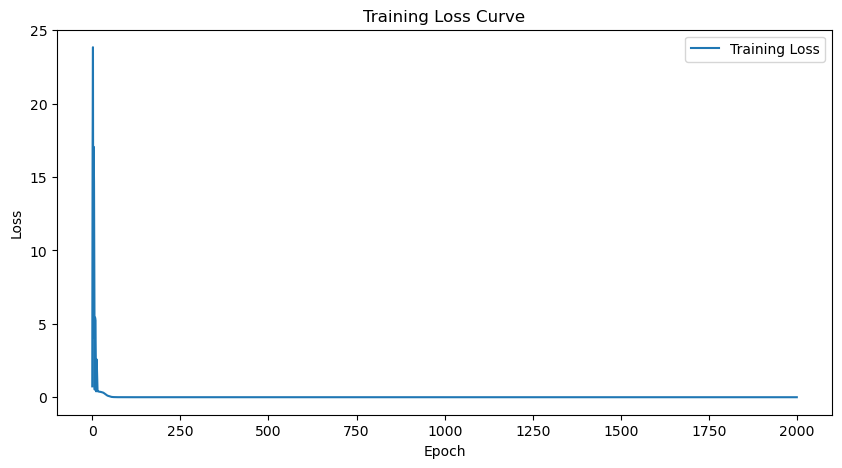

Best Model was saved at epoch 40 with F1-score 0.7857 and accuracy 78.57%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 78.57%
                  precision    recall  f1-score   support

    infringement       0.79      0.79      0.79        14
non_infringement       0.79      0.79      0.79        14

        accuracy                           0.79        28
       macro avg       0.79      0.79      0.79        28
    weighted avg       0.79      0.79      0.79        28



/tmp/ipykernel_3114676/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
